In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
train=torch.load('lorenz_test.pt')

In [3]:
training_data=train['data']
time_steps=training_data.shape[1]

In [266]:
train['data'].shape

torch.Size([256, 1024, 3])

Dimensions of x(t): (1024, 3)


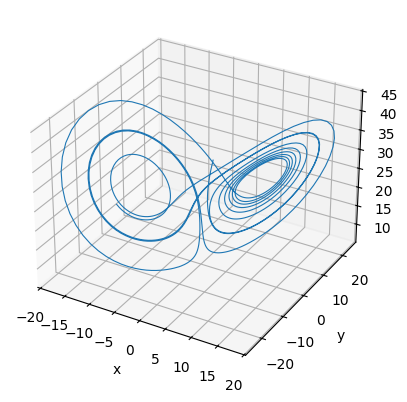

In [7]:
traj = train['data'][0,:,:].numpy()  
print(f"Dimensions of x(t): {traj.shape}")

# Plot 3D trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], lw=0.8)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [274]:
class Autoencoder(nn.Module):
    def __init__(self, time_steps=1024):
        super().__init__()
        self.bandwidth=3
        self.koopman_dimension=32
        # register Koopman matrix as a Parameter
        K = torch.zeros(self.koopman_dimension, self.koopman_dimension)
        for i in range(self.bandwidth+1):
            if i == 0:
                vals = torch.randn(self.koopman_dimension)
                K += torch.diagflat(vals)
            else:
                vals_p = torch.randn(self.koopman_dimension-i)
                vals_m = torch.randn(self.koopman_dimension-i)
                K += torch.diagflat(vals_p, i)
                K += torch.diagflat(vals_m, -i)
        K = K / (self.koopman_dimension**0.5)
        self.koopman_matrix = nn.Parameter(K)  # <-- now it's a Parameter

        self.time_steps = time_steps

        self.encode = nn.Sequential(
            nn.Linear(3,500),
            nn.Linear(500,32),
            nn.LayerNorm(32)
        )
        self.decode = nn.Sequential(
            nn.Linear(32,500),
            nn.Linear(500,3)
        )

    def compute_dynamics(self):
        return torch.stack([
            torch.linalg.matrix_power(self.koopman_matrix, step)
            for step in range(self.time_steps)
        ])

    def forward(self,x):
        x=self.encode(x)
        x=self.evolve_koopman(x)
        x=self.decode(x)
        return x

model=Autoencoder()

In [269]:
print(
    model.koopman_dynamics.shape,
    model.encode(training_data)[0,0].shape,
    torch.einsum(
        'ijk,k->ij',
        model.koopman_dynamics,
        model.encode(training_data[0,0])
    )[3],
    torch.matrix_power(model.koopman_matrix,3)@(model.encode(training_data[0,0]))
)


torch.Size([1024, 32, 32]) torch.Size([32]) tensor([-0.1509, -0.0543, -0.0638,  0.0709,  0.0521, -0.0543, -0.1062, -0.0321,
        -0.0051, -0.0345,  0.0688, -0.0253,  0.0160, -0.0455, -0.0139,  0.0362,
        -0.0085, -0.0140, -0.0310, -0.1259, -0.0402,  0.1020,  0.0333,  0.0139,
         0.0438, -0.2707,  0.1693, -0.0185,  0.0335,  0.0761, -0.0744, -0.0715],
       grad_fn=<SelectBackward0>) tensor([-0.1509, -0.0543, -0.0638,  0.0709,  0.0521, -0.0543, -0.1062, -0.0321,
        -0.0051, -0.0345,  0.0688, -0.0253,  0.0160, -0.0455, -0.0139,  0.0362,
        -0.0085, -0.0140, -0.0310, -0.1259, -0.0402,  0.1020,  0.0333,  0.0139,
         0.0438, -0.2707,  0.1693, -0.0185,  0.0335,  0.0761, -0.0744, -0.0715],
       grad_fn=<MvBackward0>)


In [270]:
print(training_data.shape)
print(torch.linalg.matrix_power(mat,2))
print(mat @ mat)

torch.Size([256, 1024, 3])
tensor([[ 2.4842,  3.0099,  1.5004,  0.0688],
        [ 0.9397,  2.3994,  0.1965, -0.2143],
        [ 2.7500,  6.5327,  1.0483,  3.0191],
        [ 3.4854,  1.5761, -0.2470,  0.9227]])
tensor([[ 2.4842,  3.0099,  1.5004,  0.0688],
        [ 0.9397,  2.3994,  0.1965, -0.2143],
        [ 2.7500,  6.5327,  1.0483,  3.0191],
        [ 3.4854,  1.5761, -0.2470,  0.9227]])


In [271]:
print(
model.encode(training_data).shape,
model.encode(training_data[:,0,:]).shape,
model.encode(training_data).shape
)

torch.einsum(
    'ijk,rk->rik',
    model.koopman_dynamics,
    model.encode(training_data[:,0,:])
).shape


torch.Size([256, 1024, 32]) torch.Size([256, 32]) torch.Size([256, 1024, 32])


torch.Size([256, 1024, 32])

In [272]:
training_data=train['data']
model=Autoencoder()

autoencoding=model.decode(model.encode(training_data))
dynamical_evolution=model.decode(
    torch.einsum(
        'ijk,rk->rik',
        model.koopman_dynamics,
        model.encode(training_data[:,0,:])
    )
)
loss_0 = nn.MSELoss()
loss_1 = nn.MSELoss()
loss_2 = (model.koopman_matrix**2).sum()
loss = sum(
    [loss_0(training_data,autoencoding),
    loss_1(training_data,dynamical_evolution),
    loss_2]
)
loss

tensor(526.8297, grad_fn=<AddBackward0>)

In [277]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# --- Hyperparameters (change if needed) ---
batch_size = 32
epochs = 100
lr = 1e-3
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
model.to(device)
training_data = training_data.to(device)

#training_data: tensor shape [N_trajectories, N_times, D] e.g. [256, 1024, 3]
model.to(device)
training_data = training_data.to(device)

dataset = TensorDataset(training_data)           # single-tensor dataset
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)   
mse = nn.MSELoss()

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0
    total_items = 0
    for (batch,) in loader:
        # batch shape: [B, T, D]
        batch = batch.to(device)

        optimizer.zero_grad()

        # reconstruction (autoencoding)
        reconstruction = model.decode(model.encode(batch))  
        
        x0 = model.encode(batch[:, 0, :])  # shape [B, latent_dim] 
        latent_dynamics = torch.einsum('ijk,rk->rik', model.compute_dynamics(), x0)  # keep same einsum convention
        dynamical_evolution = model.decode(latent_dynamics)

        loss_0 = mse(reconstruction, batch)
        loss_1 = mse(dynamical_evolution, batch)
        loss_2 = (model.koopman_matrix ** 2).sum()     

        loss = loss_0 + loss_1 + loss_2
        loss.backward()
        optimizer.step()

        bsz = batch.shape[0]
        total_loss += loss.item() * bsz
        total_items += bsz

    avg_loss = total_loss / total_items
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d}  avg_loss={avg_loss:.6f}")


Epoch    1  avg_loss=485.445751
Epoch   10  avg_loss=254.900278
Epoch   20  avg_loss=182.931240


KeyboardInterrupt: 

In [93]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# --- Config / data ---
time_steps = training_data.shape[1]           # e.g. 1024
input_dimension = training_data.shape[2]      # e.g. 3
latent_dimension = 32
hidden_dimension = 500
bandwidth = 3

class Autoencoder(nn.Module):
    def __init__(self, time_steps, input_dimension=3, latent_dimension=32, hidden_dimension=500, bandwidth=3):
        super().__init__()
        self.bandwidth = bandwidth
        self.koopman_dimension = latent_dimension
        self.time_steps = time_steps

        # build initial structured Koopman matrix and register as a Parameter
        K = torch.zeros(self.koopman_dimension, self.koopman_dimension)
        for offset in range(0, self.bandwidth + 1):
            if offset == 0:
                vals = torch.randn(self.koopman_dimension)
                K += torch.diag(vals)
            else:
                vals_p = torch.randn(self.koopman_dimension - offset)
#                vals_m = torch.randn(self.koopman_dimension - offset)
                K += torch.diag(vals_p, offset)
                K += -torch.diag(vals_p, -offset)
        K = K / (self.koopman_dimension ** 0.5)
        self.koopman_matrix = nn.Parameter(K)

        # encoder / decoder (kept same structure as original)
        self.encode = nn.Sequential(
            nn.Linear(input_dimension, hidden_dimension),
            nn.ReLU(),
            nn.Linear(hidden_dimension, latent_dimension),
            nn.LayerNorm(latent_dimension)
        )
        self.decode = nn.Sequential(
            nn.Linear(latent_dimension, hidden_dimension),
            nn.ReLU(),
            nn.Linear(hidden_dimension, input_dimension)
        )


    def compute_dynamics(self):
        with torch.no_grad():
            K = self.koopman_matrix.detach()
            #device = K.device
            dtype = K.dtype
            powers = []
            K_power = torch.eye(self.koopman_dimension, dtype=dtype)
            for _ in range(self.time_steps):
                powers.append(K_power)
                K_power = K_power @ K
            koopman_dynamics = torch.stack(powers, dim=0)
        return koopman_dynamics


    def evolve_koopman(self, x, steps=1):
        Kj = torch.linalg.matrix_power(self.koopman_matrix, steps)
        return torch.einsum('ij,...j->...i', Kj, x)

    def forward(self, x):
        x = self.encode(x)
        x = self.evolve_koopman(x)
        x = self.decode(x)
        return x

model = Autoencoder(time_steps=time_steps,
                    input_dimension=input_dimension,
                    latent_dimension=latent_dimension,
                    hidden_dimension=hidden_dimension,
                    bandwidth=bandwidth)


In [145]:
?torch.autograd.Variable

Init signature: torch.autograd.Variable(self, /, *args, **kwargs)
Docstring:      <no docstring>
File:           ~/venvs/python3.12-jupyter/lib/python3.12/site-packages/torch/autograd/variable.py
Type:           VariableMeta
Subclasses:     

In [142]:
#device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))


#model.to(device)

#training_data = training_data.to(device)   # training_data shape [N_trajectories, time_steps, input_dimension]

# --- DataLoader ---
batch_size = 32
max_time=100
short_training_data = training_data[:,:max_time,:]
dataset = TensorDataset(short_training_data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)

model = Autoencoder(time_steps=max_time,
                    input_dimension=input_dimension,
                    latent_dimension=latent_dimension,
                    hidden_dimension=hidden_dimension,
                    bandwidth=bandwidth)

# --- Optimizer / loss ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

# --- Training loop ---
epochs = 1000
print_rate=epochs/10
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0
    total_items = 0

    koopman_dynamics = model.compute_dynamics()   # shape [time_steps, D, D]

    for (batch,) in loader:
        #batch = batch.to(device)   # shape [batch_size, time_steps, input_dimension]

        optimizer.zero_grad()

        # reconstruction (autoencoding of entire trajectory)
        reconstruction = model.decode(model.encode(batch))   # [batch_size, time_steps, input_dimension]

        # dynamical evolution from t=0 latent
        x0 = model.encode(batch[:, 0, :])                    # [batch_size, latent_dimension]
        latent_dynamics = torch.einsum('ijk,rk->rik', koopman_dynamics, x0)  # [batch_size, time_steps, latent_dimension]
        dynamical_evolution = model.decode(latent_dynamics)                 # [batch_size, time_steps, input_dimension]

        loss_0 = mse(reconstruction, batch)
        loss_1 = mse(dynamical_evolution, batch)
        loss_2 = (model.koopman_matrix ** 2).sum()

        loss = loss_0+100*loss_1+0*loss_2
        if loss.item() < 0.9:
            break

        loss.backward()
        optimizer.step()

        batch_size_actual = batch.shape[0]
        total_loss += loss.item() * batch_size_actual
        total_items += batch_size_actual

    average_loss = total_loss / total_items
    if epoch % print_rate == 0 or epoch == 1:
        print(f"Epoch {epoch:4d}  average_loss={average_loss:.6f}")

Epoch    1  average_loss=27243.577148
Epoch  100  average_loss=6880.522827
Epoch  200  average_loss=6668.776184
Epoch  300  average_loss=6558.994751
Epoch  400  average_loss=6491.395325
Epoch  500  average_loss=6436.597046
Epoch  600  average_loss=6404.956726
Epoch  700  average_loss=6366.716370
Epoch  800  average_loss=6330.471741
Epoch  900  average_loss=6297.213867
Epoch 1000  average_loss=6271.564697


In [129]:
'''Epoch    1  average_loss=479.808910
Epoch   10  average_loss=244.334585
Epoch   20  average_loss=138.784384
Epoch   30  average_loss=81.743046
Epoch   40  average_loss=72.829331
Epoch   50  average_loss=72.184898
Epoch   60  average_loss=72.285035
Epoch   70  average_loss=71.797285
Epoch   80  average_loss=71.645616
Epoch   90  average_loss=71.656656
Epoch  100  average_loss=71.711755'''

'Epoch    1  average_loss=479.808910\nEpoch   10  average_loss=244.334585\nEpoch   20  average_loss=138.784384\nEpoch   30  average_loss=81.743046\nEpoch   40  average_loss=72.829331\nEpoch   50  average_loss=72.184898\nEpoch   60  average_loss=72.285035\nEpoch   70  average_loss=71.797285\nEpoch   80  average_loss=71.645616\nEpoch   90  average_loss=71.656656\nEpoch  100  average_loss=71.711755'

In [144]:
loss_list=[loss_0,loss_1,loss_2]
loss_list

[tensor(0.7140, grad_fn=<MseLossBackward0>),
 tensor(58.6936, grad_fn=<MseLossBackward0>),
 tensor(6.6883, grad_fn=<SumBackward0>)]

In [ ]:
        xidx = []
        yidx = []
        for i in range(1, 3):
            yidx.append(np.arange(i, config.n_embd))
            xidx.append(np.arange(0, config.n_embd-i))

        self.xidx = torch.LongTensor(np.concatenate(xidx))
        self.yidx = torch.LongTensor(np.concatenate(yidx))
        self.kMatrixUT = nn.Parameter(0.1*torch.rand(self.xidx.size(0)))


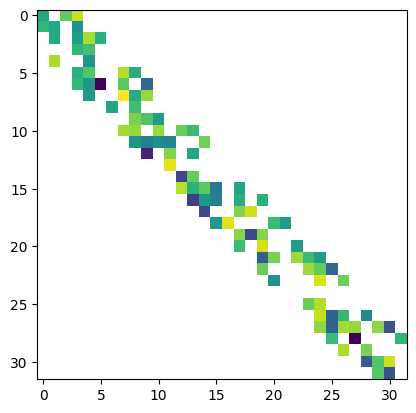

In [133]:
plt.imshow(model.koopman_matrix.cpu().detach().log().numpy())

/var/folders/zq/2rv5700n4hnb7zf8hn2trk1w0000gn/T/ipykernel_13955/2714578384.py:3: RuntimeWarning: invalid value encountered in log
  np.log(hs[hs!=0])


(array([ 1.,  0.,  1.,  1.,  6.,  7., 12., 37., 23., 18.]),
 array([-7.02916956, -6.39726973, -5.76537037, -5.13347054, -4.5015707 ,
        -3.86967087, -3.23777127, -2.60587168, -1.97397184, -1.34207201,
        -0.71017283]),
 <BarContainer object of 10 artists>)

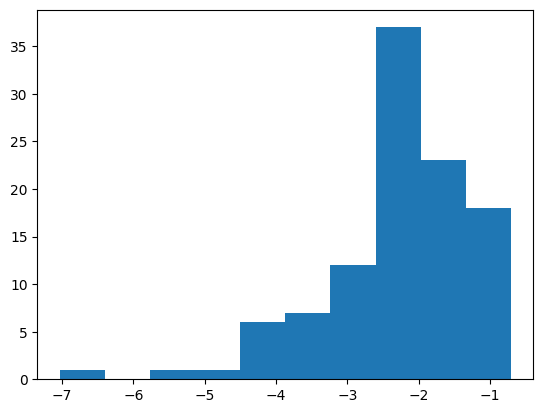

In [126]:
hs=model.koopman_matrix.cpu().detach().numpy().flatten()
plt.hist(
    np.log(hs[hs!=0])
)

In [127]:
print(

    hs[hs!=0].tolist()
    
)

[-0.27363091707229614, 0.33827605843544006, -0.05478890612721443, 0.20637384057044983, -0.33827605843544006, 0.09571096301078796, -0.07394145429134369, -0.09561480581760406, -0.08747357130050659, 0.05478890612721443, 0.07394145429134369, -0.347067266702652, -0.2733266055583954, -0.053888291120529175, -0.07414180785417557, -0.20637384057044983, 0.09561480581760406, 0.2733266055583954, 0.2036816030740738, -0.028220685198903084, 0.1052219569683075, 0.14795568585395813, 0.08747357130050659, 0.053888291120529175, 0.028220685198903084, -0.06464885920286179, 0.32525160908699036, 0.1640874743461609, 0.17913705110549927, 0.07414180785417557, -0.1052219569683075, -0.32525160908699036, -0.003652497660368681, 0.019459322094917297, 0.2226010113954544, -0.24140769243240356, -0.14795568585395813, -0.1640874743461609, -0.019459322094917297, -0.12653082609176636, 0.15693944692611694, -0.055398982018232346, -0.17930811643600464, -0.17913705110549927, -0.2226010113954544, -0.15693944692611694, -0.2701920

In [47]:
import numpy as np

In [136]:
model.compute_dynamics().shape
#predtraj=model.decode(torch.einsum('ijk,k->ik', koopman_dynamics, model.encode(train['data'][0,0,:]))).detach().numpy()
#predtraj=predtraj[:12,:]
predtraj=model.decode(model.encode(train['data'][0,:,:])).detach().numpy()
predtraj.shape
trajdiffs=traj-pred

ValueError: operands could not be broadcast together with shapes (25,3) (10,3) 

In [8]:
traj.shape
model.encode(train['data'][0,0,:])

tensor([ 0.6026,  0.0308, -1.1298, -2.1331, -0.8083, -0.8018, -0.6068,  0.1264,
         1.7182,  0.9026, -0.2017,  0.2915,  1.3865, -2.3832,  0.4924,  0.3818,
        -1.0250, -0.1184, -0.2371,  1.4283, -1.0274,  1.5693,  0.9789,  1.7036,
         0.4417, -0.6146, -0.5890, -0.3949, -0.1166, -1.3922,  1.1356,  0.5791],
       grad_fn=<NativeLayerNormBackward0>)

Dimensions of x(t): (100, 3)


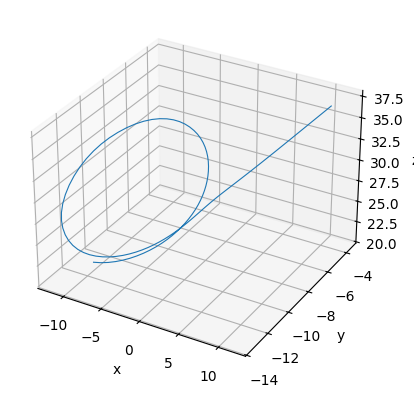

In [141]:
traj = train['data'][3,:100,:].numpy()  
print(f"Dimensions of x(t): {traj.shape}")

# Plot 3D trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], lw=0.8)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

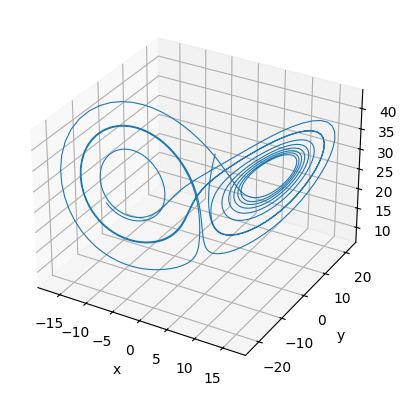

In [27]:
# Plot 3D trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(predtraj[:, 0], predtraj[:, 1], predtraj[:, 2], lw=0.8)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

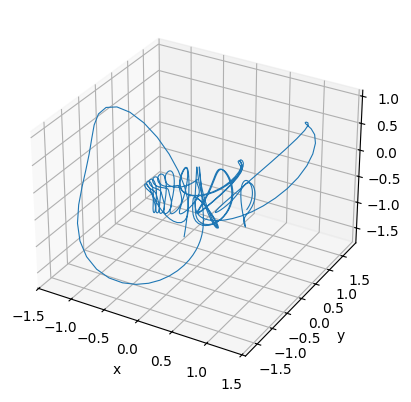

In [30]:
# Plot 3D trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajdiffs[:, 0], trajdiffs[:, 1], trajdiffs[:, 2], lw=0.8)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [32]:
print(
    loss_0,loss_1,loss_2
)

tensor(0.2646, grad_fn=<MseLossBackward0>) tensor(72.4829, grad_fn=<MseLossBackward0>) tensor(0.0095, grad_fn=<SumBackward0>)
